In [1]:
!pip install gym==0.17.3
!pip install matplotlib
!pip install tensorflow==2.10

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.4 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.17.3-py3-none-any.whl size=1654617 sha256=4f21a79552598590b81dbb7cffc6a30eeaa7952ac5a44fce6925658c1d4d3bd0
  Stored in directory: /root/.cache/pip/wheels/07/8b/b7/570cb90b10f17e85ccb291ba1f04af41ec697745104a2263eb
Successfully built gym
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 3.1.1
    Uninstalling cloudpickle-3.1.1:
      Successfully uninstalled cloudpickle-3.1.1
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.13.0 requires cloudpickl

In [2]:
import gym
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
from collections import deque
import os

In [ ]:
#baseline model

In [3]:
class DQN:
    def __init__(self,
                 InputShape,
                 NActions,
                 Gamma,
                 ReplayMemorySize,
                 MinReplayMemory,
                 UpdateTargetEveryThisEpisodes,
                 IntermediateSize ,
                 BatchSize):

        # Hyperparameters. #

        self.InputShape = InputShape
        self.NActions = NActions
        self.Gamma = Gamma
        self.ReplayMemorySize = ReplayMemorySize
        self.MinReplayMemory = MinReplayMemory
        self.UpdateTargetEveryThisEpisodes = UpdateTargetEveryThisEpisodes
        self.IntermediateSize = IntermediateSize
        self.BatchSize = BatchSize

        # Main model. #

        self.Main = self.CreateModel('Main')
        self.Optimiser = Adam()

        # Target model. #

        self.Target = self.CreateModel('Target')
        self.Target.set_weights(self.Main.get_weights())

        # Replay memory. #

        self.ReplayMemory = deque(maxlen = ReplayMemorySize)

        # Target network update counter. #

        self.TargetUpdateCounter = 0

    # new: track all batch‐losses, and per‐episode averages
        self.loss_history = []                # flat list of every batch loss
        self.episode_loss_averages = []       # one float per episode

    def CreateModel(self, Type):
        inputs = Input(shape = (self.InputShape), name = 'Input')
        x = Dense(self.IntermediateSize, activation = 'relu', name = '1stHiddenLayer')(inputs)
        x = Dense(self.IntermediateSize, activation = 'relu', name = '2ndHiddenLayer')(x)
        outputs = Dense(self.NActions, activation = 'linear', name = 'Output')(x)

        NN = Model(inputs, outputs, name = f'{Type}')
        NN.summary()

        return NN

    def UpdateReplayMemory(self, Information): # Information = (S, A, R, SNext, Done)
        self.ReplayMemory.append(Information)

    def Train(self, EndOfEpisode):

        # Only train if replay memory has enough data. #

        if len(self.ReplayMemory) < self.MinReplayMemory:
            print(f'DID NOT TRAIN..., replay memory = {len(self.ReplayMemory)}')
            return

        # Get batch of data for training. #

        TrainingData = random.sample(self.ReplayMemory, self.BatchSize)

        # Get states from training data, then get corresponding Q values. #

        ListOfS = np.array([element[0] for element in TrainingData])
        ListOfQ = np.array(self.Main(ListOfS))

        # Get future states from training data, then get corresponding Q values. #

        ListOfSNext = np.array([element[3] for element in TrainingData])
        ListOfQNext = self.Target(ListOfSNext)

        # Build actual training data for neural network. #

        X = []
        Y = []
        for index, (S, A, R, SNext, Done) in enumerate(TrainingData):
            if not Done:
                MaxQNext = np.max(ListOfQNext[index])
                QNext = R + self.Gamma * MaxQNext
            else:
                QNext = R
            Q = ListOfQ[index]
            Q[A] = QNext

            X.append(S)
            Y.append(Q)

        # Train model using tf.GradientTape(), defined below.

        #self.GTfit(X, Y)

        # — do one gradient step and record its loss —
        loss_tensor = self.GTfit(X, Y)
        self.loss_history.append(float(loss_tensor))

        # Update target network every episode. #

        if EndOfEpisode:
            self.TargetUpdateCounter += 1

        # Update target if counter is full. #

        if self.TargetUpdateCounter >= self.UpdateTargetEveryThisEpisodes:
            self.Target.set_weights(self.Main.get_weights())
            self.TargetUpdateCounter = 0

    # This is the tf.GradientTape() which significantly speeds up training of neural networks.

    @tf.function
    def GTfit(self, X, Y):
        X_tensor = tf.convert_to_tensor(X)
        Y_tensor = tf.convert_to_tensor(Y)
        # Train the neural network with this batch of data. #

        with tf.GradientTape() as tape:
            Predictions = self.Main(tf.convert_to_tensor(X), training = True)
            loss = tf.math.reduce_mean(tf.math.square(tf.convert_to_tensor(Y) - Predictions))
        Grad = tape.gradient(loss, self.Main.trainable_variables)
        self.Optimiser.apply_gradients(zip(Grad, self.Main.trainable_variables))
        return loss

In [4]:
#params that doesnt change
env = gym.make('Pendulum-v0')

statesize=env.observation_space.shape[0]

numaction=21
action_bins = np.linspace(-2, 2, numaction)
print(action_bins)


EpsilonMin   = 0.01
EpsilonDecay = 0.995
Epsilon = 0.1
ShowEvery = 10

base_agent = DQN(
    InputShape=statesize,
    NActions=numaction,
    Gamma=0.99,
    ReplayMemorySize=100000,
    MinReplayMemory=320,
    UpdateTargetEveryThisEpisodes=ShowEvery,
    IntermediateSize=64,
    BatchSize=64
)


[-2.  -1.8 -1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6
  0.8  1.   1.2  1.4  1.6  1.8  2. ]


ValueError: Cannot convert '3' to a shape.

In [ ]:
def PendulumActionConverter(A, NActions=numaction):
    ActualTorque = (A / NActions - 0.5) * 4
    return ActualTorque

def PendulumInverseActionConverter(A, NActions=numaction):
    ActualA = round((A + 2) * (NActions - 1) / 4)
    return(ActualA)

def OneEpisode(agent, env, action_bins):
    S = env.reset()
    Done = False
    total_reward = 0

    while not Done:
        # 1) get Q-values from *this* agent
        q_vals = agent.Main(S.reshape(1, -1), training=False).numpy()[0]

        # 2) ε-greedy
        if np.random.rand() < Epsilon:
            A = np.random.randint(0, agent.NActions)#A = env.action_space.sample()
        else:
            A = np.argmax(q_vals)

        # 3) step
        SNext, R, Done, _ = env.step([action_bins[A]])
        total_reward += R

        env.render()
        # 4) store & train
        agent.UpdateReplayMemory((S, A, R, SNext, Done))
        agent.Train(EndOfEpisode=False)

        S = SNext

    # 5) at episode end, do one more Train() with EndOfEpisode=True
    agent.Train(EndOfEpisode=True)

    return total_reward


In [5]:
import time
def train_agent(base_agent, env, action_bins, episodes=500,early_stopping_threshold= -200,Epsilon=Epsilon,EpsilonDecay=EpsilonDecay,EpsilonMin=EpsilonMin):


    STARTTIME = time.time()

    reward_history = []
    epsilon_history = []



    for ep in range(episodes):
        ep_start = time.time()

        # track where this episode’s losses begin
        start_idx = len(base_agent.loss_history)

        # run one episode
        total_reward = OneEpisode(base_agent, env, action_bins)
        reward_history.append(total_reward)

        # decay epsilon
        Epsilon = max(EpsilonMin, Epsilon * EpsilonDecay)
        epsilon_history.append(Epsilon)

        # episode-level loss average
        ep_losses = base_agent.loss_history[start_idx:]
        ep_loss = sum(ep_losses) / len(ep_losses) if ep_losses else 0.0

        # reward stats
        avg_reward = sum(reward_history) / len(reward_history)
        last20_avg_reward = sum(reward_history[-20:]) / len(reward_history[-20:])

        # ✅ Early stopping if learning is "good enough"
        if last20_avg_reward > early_stopping_threshold:  # define your threshold
            print(f"✅ Early stopping at episode {ep+1} with last20_avg_reward = {last20_avg_reward:.2f}")
            break


        # duration
        ep_time = time.time() - ep_start

        print(
            f"Episode {ep+1:3d} | "
            f"Time: {ep_time:5.2f}s | "
            f"Reward: {total_reward:7.2f} | "
            f"AvgReward: {avg_reward:7.2f} | "
            f"Last20AvgReward: {last20_avg_reward:7.2f} | "
            f"Loss: {ep_loss:.4f} | "
            f"ε: {Epsilon:.4f}"
        )

    print(f"\nTotal time taken: {time.time() - STARTTIME:.2f}s")

    return reward_history, epsilon_history

In [ ]:
reward_history, epsilon_history = train_agent(base_agent, env, action_bins, episodes=500,early_stopping_threshold= -200,Epsilon=Epsilon,
    EpsilonDecay=EpsilonDecay,
    EpsilonMin=EpsilonMin)


DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27
DID NOT TR

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_episode_rewards(reward_history):
    plt.figure(figsize=(10, 4))
    plt.plot(reward_history, label='Episode Reward')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Episode Reward over Time')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_moving_avg(reward_history, window=20):
    moving_avg = np.convolve(reward_history, np.ones(window)/window, mode='valid')
    plt.figure(figsize=(10, 4))
    plt.plot(moving_avg, label=f'Moving Avg (window={window})', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title(f'Moving Average Reward (Last {window} Episodes)')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_epsilon(epsilon_history):
    if epsilon_history is not None and len(epsilon_history) > 0:
        plt.figure(figsize=(10, 4))
        plt.plot(epsilon_history, label='Epsilon', color='green')
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')
        plt.title('Epsilon Decay Over Time')
        plt.grid(True)
        plt.legend()
        plt.show()
    else:
        print("No epsilon history to plot.")

def plot_loss(loss_history):
    plt.figure(figsize=(10, 4))
    plt.plot(loss_history, label='Loss', color='red')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title('Loss per Episode')
    plt.grid(True)
    plt.legend()
    plt.show()



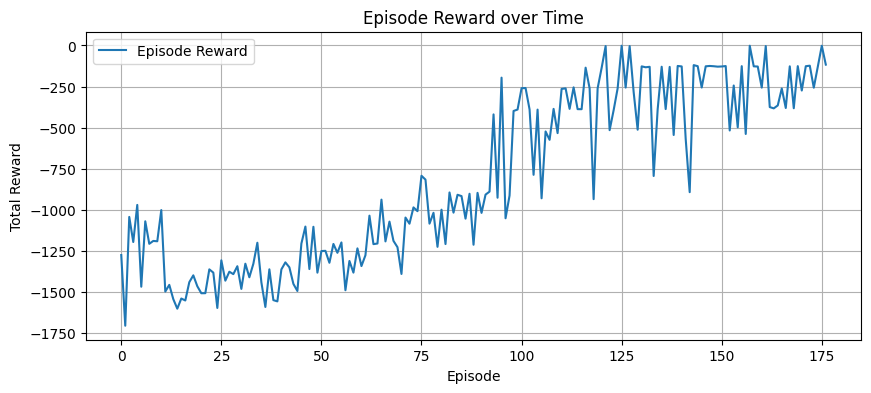

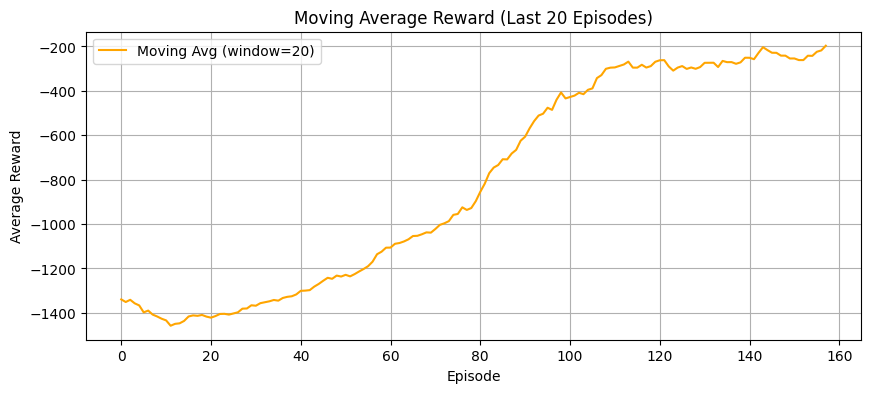

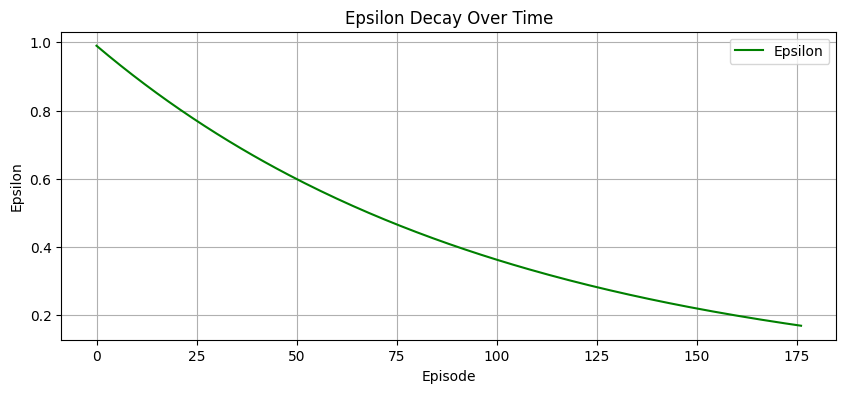

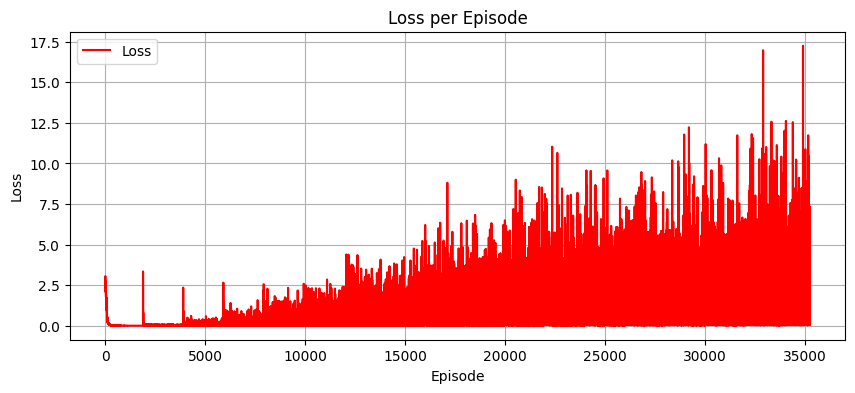

In [ ]:
plot_episode_rewards(reward_history)
plot_moving_avg(reward_history, window=20)
plot_epsilon(epsilon_history)
plot_loss(base_agent.loss_history)



In [ ]:
'''
Implement:
🧠 Tunable Network Architecture:

layer1_num, layer2_num, optional layer3_num

Activation function as parameter (ActivationFn)

📥 Input Normalization:

Use preprocess_state() with scaling for state[2]

🎯 Hard Target Network Update:

self.Target.set_weights(self.Main.get_weights()) every N episodes

🏁 Early Stopping + Model Saving:

Save model if last20_avg_reward exceeds threshold:




'''

In [7]:
class ImprovedDQN(DQN):
    def __init__(self,
                 InputShape,
                 NActions,
                 Gamma,
                 ReplayMemorySize,
                 MinReplayMemory,
                 UpdateTargetEveryThisEpisodes,
                 BatchSize,
                 layer1_num=64,
                 layer2_num=64,
                 use_layer3=False,
                 layer3_num=64,
                 ActivationFn='relu',
                 LearningRate=0.001):


        # Override/add architecture params
        self.layer1_num = layer1_num
        self.layer2_num = layer2_num
        self.layer3_num = layer3_num
        self.use_layer3 = use_layer3
        self.ActivationFn = ActivationFn
        self.LearningRate = LearningRate


        # Call parent constructor
        super().__init__(InputShape, NActions, Gamma, ReplayMemorySize,
                         MinReplayMemory, UpdateTargetEveryThisEpisodes,
                         IntermediateSize=layer1_num,  # Just to keep compatibility
                         BatchSize=BatchSize)

        # Rebuild models with new architecture
        self.Main = self.CreateModel('Main')
        self.Target = self.CreateModel('Target')
        self.Target.set_weights(self.Main.get_weights())

        # New optimiser (uses custom LR)
        self.Optimiser = Adam(learning_rate=self.LearningRate)

    def CreateModel(self, Type):
        inputs = Input(shape=(self.InputShape,), name='Input')
        x = Dense(self.layer1_num, activation=self.ActivationFn, name='1stHiddenLayer')(inputs)
        x = Dense(self.layer2_num, activation=self.ActivationFn, name='2ndHiddenLayer')(x)
        if self.use_layer3:
            x = Dense(self.layer3_num, activation=self.ActivationFn, name='3rdHiddenLayer')(x)
        outputs = Dense(self.NActions, activation='linear', name='Output')(x)

        model = Model(inputs, outputs, name=f'{Type}')
        model.summary()
        return model






    @tf.function
    def GTfit(self, X, Y):
        X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
        Y_tensor = tf.convert_to_tensor(Y, dtype=tf.float32)

        with tf.GradientTape() as tape:
            predictions = self.Main(X_tensor, training=True)
            loss = tf.reduce_mean(tf.square(Y_tensor - predictions))
        grads = tape.gradient(loss, self.Main.trainable_variables)
        self.Optimiser.apply_gradients(zip(grads, self.Main.trainable_variables))
        return loss


In [18]:
def preprocess_state(state):
    state = np.array(state, dtype=np.float32)
    state[2] = state[2] / 8.0  # ✅ Normalize θ̇
    return state

def OneEpisode(agent, env, action_bins, epsilon):
    S = preprocess_state(env.reset())
    Done = False
    total_reward = 0
    max_steps = 200
    steps = 0

    while not Done and steps < max_steps:
        q_vals = agent.Main(S.reshape(1, -1), training=False).numpy()[0]
        A = np.random.randint(0, agent.NActions) if np.random.rand() < epsilon else np.argmax(q_vals)
        SNext, R, Done, _ = env.step([action_bins[A]])
        SNext = preprocess_state(SNext)

        total_reward += R
        agent.UpdateReplayMemory((S, A, R, SNext, Done))
        agent.Train(EndOfEpisode=False)

        S = SNext
        steps += 1

    agent.Train(EndOfEpisode=True)
    return total_reward



def train_agent(agent, env, action_bins, episodes=500, early_stopping_threshold=-200,Epsilon=Epsilon,EpsilonDecay=EpsilonDecay,EpsilonMin=EpsilonMin):
    STARTTIME = time.time()
    reward_history = []
    epsilon_history = []


    #Epsilon = 1.0
    #EpsilonDecay = 0.990
    #EpsilonMin = 0.01
    best_avg_reward = -np.inf

    for ep in range(episodes):
        ep_start = time.time()
        start_idx = len(agent.loss_history)


        total_reward = OneEpisode(agent, env, action_bins, Epsilon)
        reward_history.append(total_reward)

        Epsilon = max(EpsilonMin, Epsilon * EpsilonDecay)
        epsilon_history.append(Epsilon)

        ep_losses = agent.loss_history[start_idx:]
        ep_loss = sum(ep_losses) / len(ep_losses) if ep_losses else 0.0

        avg_reward = sum(reward_history) / len(reward_history)
        last20_avg_reward = sum(reward_history[-20:]) / len(reward_history[-20:])
        ep_time = time.time() - ep_start
        print(f"Episode {ep+1} |Time: {ep_time:5.2f}s | Reward: {total_reward:.2f} | Avg: {avg_reward:.2f} | Last20Avg: {last20_avg_reward:.2f} | ε: {Epsilon:.4f} | Loss: {ep_loss:.4f}")

        # ✅ Save and stop if this is the best so far and good enough
        if last20_avg_reward > early_stopping_threshold:
            best_avg_reward = last20_avg_reward
            agent.Main.save("best_model.h5")
            print(f"📦 Saved best model at Episode {ep+1} (avg reward: {best_avg_reward:.2f})")
            print(f"✅ Early stopping at episode {ep+1} with last20_avg_reward = {last20_avg_reward:.2f}")
            break

    print(f"\nTotal time taken: {time.time() - STARTTIME:.2f}s")
    return reward_history, epsilon_history


In [19]:
IDQN = ImprovedDQN(
    InputShape=statesize,
    NActions=numaction,
    Gamma=0.99,
    ReplayMemorySize=100000,
    MinReplayMemory=320,
    UpdateTargetEveryThisEpisodes=10,
    BatchSize=64,
    layer1_num=128,
    layer2_num=64,
    use_layer3=True,
    layer3_num=32,
    ActivationFn='tanh',
    LearningRate=0.0005
)

EpsilonDecay = 0.990


Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3rdHiddenLayer (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 21)             │           693 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,541 (45.08 KB)

 Trainable params: 11,541 (45.08 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3rdHiddenLayer (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 21)             │           693 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,541 (45.08 KB)

 Trainable params: 11,541 (45.08 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3rdHiddenLayer (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 21)             │           693 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,541 (45.08 KB)

 Trainable params: 11,541 (45.08 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 3rdHiddenLayer (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 21)             │           693 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,541 (45.08 KB)

 Trainable params: 11,541 (45.08 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
reward_history, epsilon_history = train_agent(
    agent=IDQN,
    env=env,
    action_bins=action_bins,
    episodes=500,                     # or longer if needed
    early_stopping_threshold=-200,   # stop once last 20 episodes beat this
    Epsilon=Epsilon,
    EpsilonDecay=EpsilonDecay,
    EpsilonMin=EpsilonMin
)


DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27
DID NOT TR

Episode 204 |Time:  7.53s | Reward: -122.95 | Avg: -641.04 | Last20Avg: -158.63 | ε: 0.0129 | Loss: 1.1518
📦 Saved best model at Episode 204 (avg reward: -158.63)
✅ Early stopping at episode 204 with last20_avg_reward = -158.63

Total time taken: 1499.22s


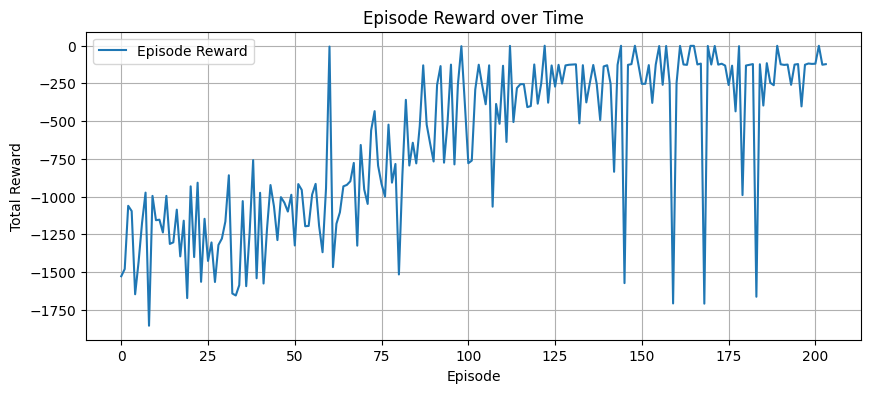

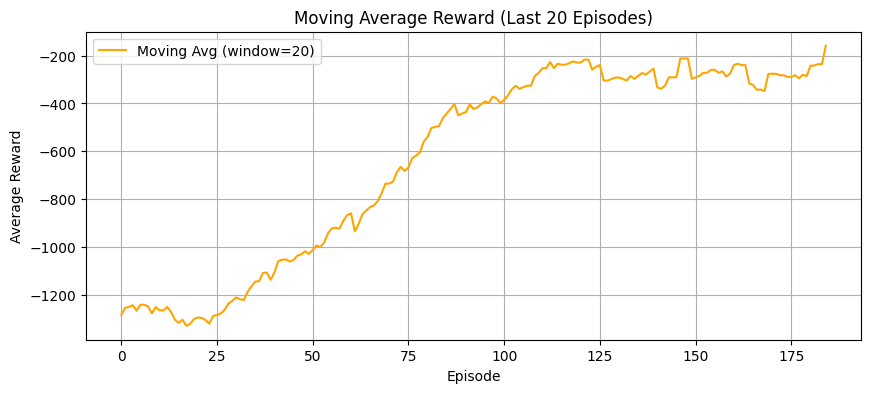

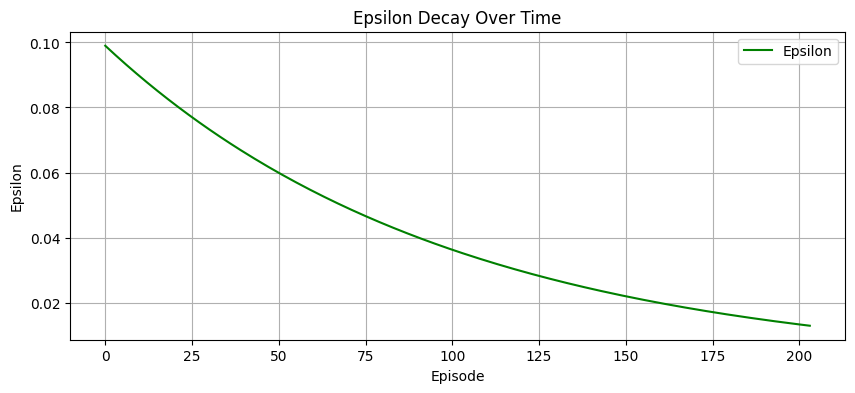

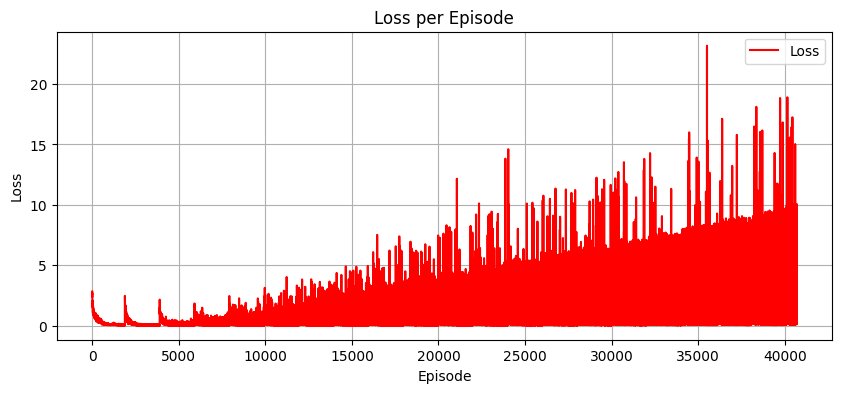

In [24]:
plot_episode_rewards(reward_history)
plot_moving_avg(reward_history, window=20)
plot_epsilon(epsilon_history)
plot_loss(IDQN.loss_history)


In [ ]:
IDQN = ImprovedDQN(
    InputShape=statesize,
    NActions=numaction,
    Gamma=0.99,
    ReplayMemorySize=100000,
    MinReplayMemory=320,
    UpdateTargetEveryThisEpisodes=10,
    BatchSize=64,
    layer1_num=128,
    layer2_num=64,
    use_layer3=True,
    layer3_num=32,
    ActivationFn='tanh',
    LearningRate=0.0005
)

EpsilonDecay = 0.990


In [ ]:
reward_history, epsilon_history = train_agent(
    agent=IDQN,
    env=env,
    action_bins=action_bins,
    episodes=500,                     # or longer if needed
    early_stopping_threshold=-200,   # stop once last 20 episodes beat this
    Epsilon=Epsilon,
    EpsilonDecay=EpsilonDecay,
    EpsilonMin=EpsilonMin
)


In [27]:
# Prepare data for plotting
# trajectory_log is not directly available in this setup, using policy_state_log for now
# You might need to log this during training if a specific trajectory is needed.

policy_state_log = []
policy_action_log = []
entropy_map = np.zeros((100, 100))

theta_vals = np.linspace(-np.pi, np.pi, 100)
theta_dot_vals = np.linspace(-8, 8, 100)

for i, θ in enumerate(theta_vals):
    for j, θ_dot in enumerate(theta_dot_vals):
        state = np.array([np.cos(θ), np.sin(θ), θ_dot])
        # Use IDQN agent to get Q-values
        q_vals = IDQN.Main(state.reshape(1, -1)).numpy()[0]

        action_probs = tf.nn.softmax(q_vals).numpy()
        entropy = -np.sum(action_probs * np.log(action_probs + 1e-10))

        entropy_map[i, j] = entropy
        policy_action_log.append(np.argmax(q_vals))
        policy_state_log.append([θ, θ_dot])

trajectory_log = np.array(policy_state_log) # Using collected states as a proxy

# These variables are available from the training run
episode_rewards = reward_history # Already have this
loss_log = IDQN.loss_history # Use the raw loss history from the agent
state_history = np.array(policy_state_log) # Already collected in the policy_state_log
action_history = np.array(policy_action_log) # Already collected in the policy_action_log

# Reshape the policy action log to create the policy map
policy_map = np.array(policy_action_log).reshape(100, 100).T


plot_training_summary(
    trajectory_log=trajectory_log,
    episode_rewards=episode_rewards,
    loss_log=loss_log, # Using the raw loss history
    state_history=state_history,
    action_history=action_history,
    action_map=policy_map,
    entropy_map=entropy_map # Already calculated
)

NameError: name 'plot_training_summary' is not defined

In [ ]:
policy_state_log = []
policy_action_log = []
entropy_map = np.zeros((100, 100))

theta_vals = np.linspace(-np.pi, np.pi, 100)
theta_dot_vals = np.linspace(-8, 8, 100)

for i, θ in enumerate(theta_vals):
    for j, θ_dot in enumerate(theta_dot_vals):
        state = np.array([np.cos(θ), np.sin(θ), θ_dot])
        q_vals = agent.Main(state.reshape(1, -1)).numpy()[0]

        action_probs = tf.nn.softmax(q_vals).numpy()
        entropy = -np.sum(action_probs * np.log(action_probs + 1e-10))

        entropy_map[i, j] = entropy
        policy_action_log.append(np.argmax(q_vals))
        policy_state_log.append([θ, θ_dot])


In [ ]:
from matplotlib.lines import Line2D
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import numpy as np

def plot_training_summary(
    trajectory_log,
    episode_rewards,
    loss_log,
    state_history,
    action_history,
    action_map,
    entropy_map,
    title="Pendulum DQN Training Summary"
):
    # Convert lists to arrays
    traj_log = np.array(trajectory_log)
    episode_rewards = np.array(episode_rewards)
    loss_log = np.array(loss_log)
    state_history = np.array(state_history)
    action_history = np.array(action_history)

    # Smooth reward and loss
    smoothed_rewards = gaussian_filter1d(episode_rewards, sigma=10)
    smoothed_loss = gaussian_filter1d(loss_log, sigma=5)

    # Create figure
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    # 1. Action Entropy
    im0 = axs[0, 0].imshow(
        entropy_map.T,
        extent=[-np.pi, np.pi, -8, 8],
        origin='lower',
        aspect='auto',
        cmap='viridis',
        interpolation='nearest'
    )
    axs[0, 0].set_title("Action Entropy over State Space")
    axs[0, 0].set_xlabel("θ (angle)")
    axs[0, 0].set_ylabel("θ̇ (angular velocity)")
    cbar0 = fig.colorbar(im0, ax=axs[0, 0])
    cbar0.set_label("Entropy")

    # 2. Q-Loss Over Time
    axs[0, 1].plot(loss_log, color='green', label='Q-Loss', alpha=0.3)
    axs[0, 1].plot(smoothed_loss, color='orange', label='Smoothed Q-Loss')
    axs[0, 1].set_title("Loss Over Time")
    axs[0, 1].set_xlabel("Episode")
    axs[0, 1].set_ylabel("Loss")
    axs[0, 1].legend()

    # 3. Policy Map
    cmap = plt.get_cmap('RdYlBu', 3)
    im = axs[0, 2].imshow(action_map, extent=[-np.pi, np.pi, -8, 8], origin='lower', aspect='auto', cmap=cmap)
    axs[0, 2].set_title("Policy Map")
    axs[0, 2].set_xlabel("θ (rad)")
    axs[0, 2].set_ylabel("θ̇")

    # Custom legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Push Left', markerfacecolor=cmap(0/2), markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Do Nothing', markerfacecolor=cmap(1/2), markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Push Right', markerfacecolor=cmap(2/2), markersize=8),
    ]
    cbar = plt.colorbar(im, ax=axs[0, 2], ticks=[0, 1, 2])
    cbar.set_ticklabels(['Push Left', 'Do Nothing', 'Push Right'])
    cbar.set_label("Action", rotation=270, labelpad=15)

    # 4. Memory Buffer
    sc = axs[1, 0].scatter(state_history[:, 0], state_history[:, 1], c=action_history, cmap=cmap, s=3, alpha=0.6)
    axs[1, 0].set_title("Memory Buffer State Coverage")
    axs[1, 0].set_xlabel("state[0]")
    axs[1, 0].set_ylabel("state[1]")
    axs[1, 0].legend(handles=legend_elements, title="Actions")

    # 5. Episode Reward Curve
    axs[1, 1].plot(episode_rewards, label="Raw Reward", alpha=0.3)
    axs[1, 1].plot(smoothed_rewards, label="Smoothed", color='orange')
    axs[1, 1].set_title("Episode Rewards Over Time")
    axs[1, 1].set_xlabel("Episode")
    axs[1, 1].set_ylabel("Reward")
    axs[1, 1].legend()

    # 6. Empty (for layout symmetry)
    axs[1, 2].axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


In [31]:
plot_training_summary(
    trajectory_log=trajectory_log,
    episode_rewards=reward_history,
    loss_log=IDQN.loss_history,
    state_history=policy_state_log,
    action_history=policy_action_log,
    action_map=policy_map,
    entropy_map=entropy_map
)

NameError: name 'plot_training_summary' is not defined

In [ ]:
base_agent = DQN(
    InputShape=statesize,
    NActions=numaction,
    Gamma=0.99,
    ReplayMemorySize=100000,
    MinReplayMemory=2000,
    UpdateTargetEveryThisEpisodes=ShowEvery,
    IntermediateSize=128,
    BatchSize=32
)
reward_history, epsilon_history = train_agent(base_agent, env, action_bins, episodes=500,early_stopping_threshold= -200)

Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 128)               512       
                                                                 
 2ndHiddenLayer (Dense)      (None, 128)               16512     
                                                                 
 Output (Dense)              (None, 21)                2709      
                                                                 
Total params: 19,733
Trainable params: 19,733
Non-trainable params: 0
_________________________________________________________________
Model: "Target"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]  

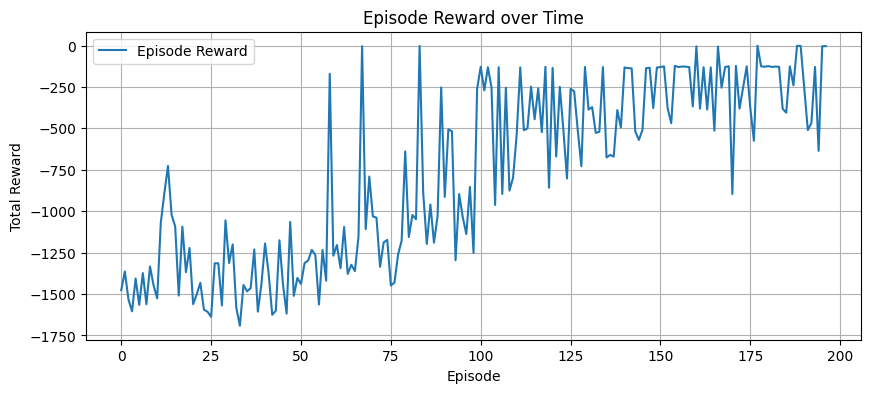

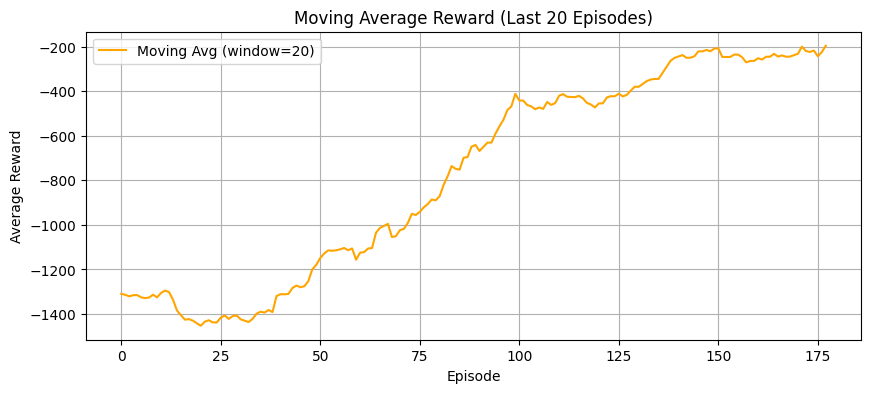

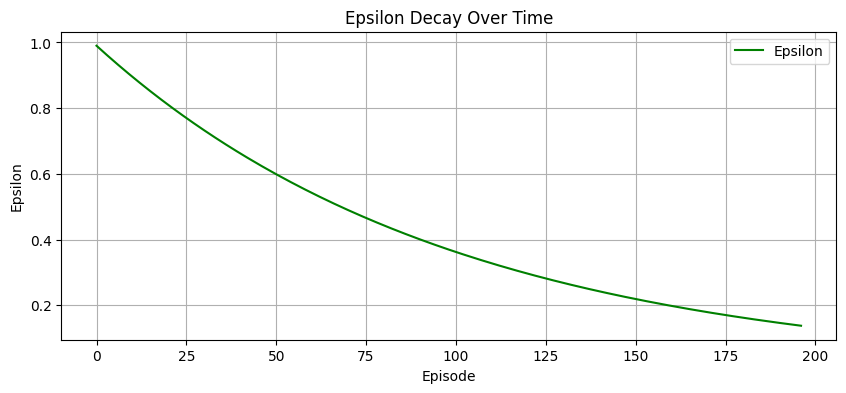

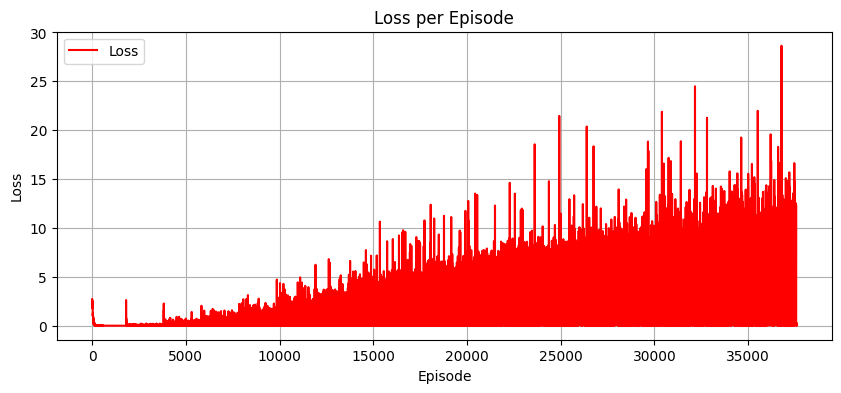

In [ ]:
plot_episode_rewards(reward_history)
plot_moving_avg(reward_history, window=20)
plot_epsilon(epsilon_history)
plot_loss(base_agent.loss_history)



In [ ]:
!pip install torch
import torch


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.13.0 requires keras<2.14,>=2.13.1, but you have keras 2.10.0 which is incompatible.
tensorflow-intel 2.13.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.
tensorflow-intel 2.13.0 requires tensorboard<2.14,>=2.13, but you have tensorboard 2.10.1 which is incompatible.
tensorflow-intel 2.13.0 requires tensorflow-estimator<2.14,>=2.13.0, but you have tensorflow-estimator 2.10.0 which is incompatible.
tensorflow-intel 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.13.2 which is incompatible.


  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
   ---------------------------------------- 0.0/199.4 MB ? eta -:--:--
   - -------------------------------------- 6.6/199.4 MB 33.5 MB/s eta 0:00:06
   --- ------------------------------------ 17.3/199.4 MB 42.0 MB/s eta 0:00:05
   ----- ---------------------------------- 28.6/199.4 MB 46.4 MB/s eta 0:00:04
   -------- ------------------------------- 42.7/199.4 MB 51.3 MB/s eta 0:00:04
   -------- ------------------------------- 43.3/199.4 MB 41.1 MB/s eta 0:00:04
   ---------- ----------------------------- 52.4/199.4 MB 43.4 MB/s eta 0:00:04
   ----------- ---------------------------- 57.7/199.4 MB 38.7 MB/s eta 0:00:04
   -------------- ------------------------- 70.3/199.4 MB 41.5 MB/s eta 0:00:04
   ---------------- ----------------------- 81.0/199.4 MB 42.4 MB/s eta 0:00:03
   ------------------ --------------------- 92.8/199.4 MB 43.5 MB/s eta 0:00:03
   -------------------- ------------------ 104.9/199.4 

Exception ignored in: <function Viewer.__del__ at 0x0000028359F90700>
Traceback (most recent call last):
  File "c:\Users\65882\anaconda3\envs\RL\lib\site-packages\gym\envs\classic_control\rendering.py", line 165, in __del__
    self.close()
  File "c:\Users\65882\anaconda3\envs\RL\lib\site-packages\gym\envs\classic_control\rendering.py", line 83, in close
    self.window.close()
  File "c:\Users\65882\anaconda3\envs\RL\lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
    super(Win32Window, self).close()
  File "c:\Users\65882\anaconda3\envs\RL\lib\site-packages\pyglet\window\__init__.py", line 823, in close
    app.windows.remove(self)
  File "c:\Users\65882\anaconda3\envs\RL\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x000002839EED79F0; to 'Win32Window' at 0x00000283894B8550>


In [ ]:
import torch

class DQN_Tuned(DQN):
    def __init__(self,
                 InputShape,
                 NActions,
                 Gamma,
                 ReplayMemorySize,
                 MinReplayMemory,
                 UpdateTargetEveryThisEpisodes,
                 IntermediateSize,
                 BatchSize,
                 LearningRate=0.001):

        # ✅ Call parent constructor (which will set up q_network)
        super().__init__(InputShape=InputShape,
                         NActions=NActions,
                         Gamma=Gamma,
                         ReplayMemorySize=ReplayMemorySize,
                         MinReplayMemory=MinReplayMemory,
                         UpdateTargetEveryThisEpisodes=UpdateTargetEveryThisEpisodes,
                         IntermediateSize=IntermediateSize,
                         BatchSize=BatchSize)

        self.lr = LearningRate

        # ✅ Only patch optimizer if q_network exists
        if hasattr(self, "q_network"):
            self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=self.lr)
        else:
            print("⚠️ q_network not initialized in base DQN. You may need to call a setup method first.")


In [ ]:

def train_agent(base_agent, env, action_bins,
                episodes=500,
                early_stopping_threshold=-200,
                Epsilon=1.0,
                EpsilonDecay=0.990,
                EpsilonMin=0.01):
    STARTTIME = time.time()

    reward_history = []
    epsilon_history = []

    # ✅ Set agent-level epsilon tracking (if your agent uses it internally)
    if hasattr(base_agent, 'epsilon'):
        base_agent.epsilon = Epsilon
    if hasattr(base_agent, 'epsilon_min'):
        base_agent.epsilon_min = EpsilonMin
    if hasattr(base_agent, 'epsilon_decay'):
        base_agent.epsilon_decay = EpsilonDecay

    for ep in range(episodes):
        ep_start = time.time()

        # track where this episode’s losses begin
        start_idx = len(base_agent.loss_history)

        # run one episode
        total_reward = OneEpisode(base_agent, env, action_bins)
        reward_history.append(total_reward)

        # decay epsilon manually (independent of agent’s method)
        Epsilon = max(EpsilonMin, Epsilon * EpsilonDecay)
        epsilon_history.append(Epsilon)

        # optional: set it back into agent (if your exploration uses this variable)
        if hasattr(base_agent, 'epsilon'):
            base_agent.epsilon = Epsilon

        # calculate average loss for this episode
        ep_losses = base_agent.loss_history[start_idx:]
        ep_loss = sum(ep_losses) / len(ep_losses) if ep_losses else 0.0

        # reward stats
        avg_reward = sum(reward_history) / len(reward_history)
        last20_avg_reward = sum(reward_history[-20:]) / len(reward_history[-20:])

        # ✅ Early stopping if good enough
        if last20_avg_reward > early_stopping_threshold:
            print(f"✅ Early stopping at episode {ep+1} with last20_avg_reward = {last20_avg_reward:.2f}")
            break

        ep_time = time.time() - ep_start

        print(
            f"Episode {ep+1:3d} | "
            f"Time: {ep_time:5.2f}s | "
            f"Reward: {total_reward:7.2f} | "
            f"AvgReward: {avg_reward:7.2f} | "
            f"Last20AvgReward: {last20_avg_reward:7.2f} | "
            f"Loss: {ep_loss:.4f} | "
            f"ε: {Epsilon:.4f}"
        )

    print(f"\nTotal time taken: {time.time() - STARTTIME:.2f}s")

    return reward_history, epsilon_history

In [ ]:
import gym
import numpy as np
import random
from itertools import product

# ---- Env setup ----
env = gym.make('Pendulum-v0')
state_size = env.observation_space.shape[0]
num_action = 21
action_bins = np.linspace(-2, 2, num_action)

# ---- Parameter grid ----
param_grid = {
    "batch_size": [32, 64, 128],
    "hidden_size": [64, 128, 256],
    "epsilon_decay": [0.995, 0.990, 0.985],
    "min_replay": [1000, 2000, 4000],
    "learning_rate": [1e-3, 5e-4, 1e-4],
    "gamma": [0.95, 0.99],
    "target_update": [5, 10],
}

# Generate all combos and sample N
all_combos = list(product(*param_grid.values()))
random.shuffle(all_combos)
sampled_combos = all_combos[:200]  # you can set 100, 150, 200 depending on time

# ---- Training loop ----
results = []

for i, combo in enumerate(sampled_combos):
    (
        batch_size, hidden_size, epsilon_decay,
        min_replay, lr, gamma, target_update
    ) = combo

    print(f"\n🔁 Config {i+1}/{len(sampled_combos)}")
    print(f"BatchSize={batch_size}, HiddenSize={hidden_size}, εDecay={epsilon_decay}, MinReplay={min_replay}, LR={lr}, γ={gamma}, TargetUpdate={target_update}")

    # Init agent with these params
    agent = DQN_Tuned(
        InputShape=state_size,
        NActions=num_action,
        Gamma=gamma,
        ReplayMemorySize=100000,
        MinReplayMemory=min_replay,
        UpdateTargetEveryThisEpisodes=target_update,
        IntermediateSize=hidden_size,
        BatchSize=batch_size,
        LearningRate=lr  # Make sure your DQN class accepts this!
    )

    # Train
    reward_history, epsilon_history = train_agent(
        agent, env, action_bins,
        episodes=500,
        early_stopping_threshold=-100,
        Epsilon=1.0,
        EpsilonMin=0.01,
        EpsilonDecay=epsilon_decay
    )

    # Evaluate
    last20_rewards = [np.mean(reward_history[i-20:i]) for i in range(20, len(reward_history))]
    success_episode = None
    for idx, avg in enumerate(last20_rewards):
        if avg >= -100:
            success_episode = idx + 20
            break

    results.append({
        "config_id": i,
        "episodes_to_success": success_episode if success_episode else 500,
        "final_avg_reward": np.mean(reward_history[-20:]),
        "batch_size": batch_size,
        "hidden_size": hidden_size,
        "epsilon_decay": epsilon_decay,
        "min_replay": min_replay,
        "learning_rate": lr,
        "gamma": gamma,
        "target_update": target_update
    })

# ---- Sort by best result ----
results.sort(key=lambda x: x["episodes_to_success"])

# ---- Show top 5 configs ----
for r in results[:5]:
    print("\n🏆 Top config:")
    print(f"Config ID: {r['config_id']}")
    print(f"Episodes to -100: {r['episodes_to_success']}")
    print(f"Final Avg Reward: {r['final_avg_reward']:.2f}")
    print(f"Params: Batch={r['batch_size']}, Hidden={r['hidden_size']}, εDecay={r['epsilon_decay']}, Replay={r['min_replay']}, LR={r['learning_rate']}, γ={r['gamma']}, TargetUpdate={r['target_update']}")



🔁 Config 1/200
BatchSize=32, HiddenSize=64, εDecay=0.995, MinReplay=1000, LR=0.001, γ=0.95, TargetUpdate=5
Model: "Main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 21)                1365      
                                                                 
Total params: 5,781
Trainable params: 5,781
Non-trainable params: 0


_________________________________________________________________
Model: "Target"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 3)]               0         
                                                                 
 1stHiddenLayer (Dense)      (None, 64)                256       
                                                                 
 2ndHiddenLayer (Dense)      (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 21)                1365      
                                                                 
Total params: 5,781
Trainable params: 5,781
Non-trainable params: 0
_________________________________________________________________
⚠️ q_network not initialized in base DQN. You may need to call a setup method first.
DID NOT TRAIN..., replay memory = 1
DID

KeyboardInterrupt: 